<a href="https://colab.research.google.com/github/CanKeles5/ImproveImgQuality/blob/main/ImageDeblurSRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data.sampler
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image, ImageFilter
import os
import cv2
import numpy
import random
import fnmatch
import numpy as np
import sys

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:08<00:00, 128MB/s]
100% 1.33G/1.33G [00:08<00:00, 175MB/s]


In [ ]:
path = "/content/celeba-dataset.zip"
to = "/content/dataset"
! unzip -q -n {path} -d {to}

In [ ]:
im_path = "/content/dataset/img_align_celeba.zip"
imgs = "/content/images"
! unzip -q -n {im_path} -d {imgs}

unzip:  cannot find or open /content/dataset/img_align_celeba.zip, /content/dataset/img_align_celeba.zip.zip or /content/dataset/img_align_celeba.zip.ZIP.


In [ ]:
folder = "/content/dataset/img_align_celeba/img_align_celeba"

In [ ]:
image_paths = []

for (path, dirnames, filenames) in os.walk(folder):
  image_paths.extend(os.path.join(path, name) for name in filenames)

In [ ]:
class MyDataset(Dataset):
  def __init__(self, image_paths, train=True):
    self.image_paths = image_paths
    
  def transform(self, image):
    resize = transforms.Resize(size=(128, 128))
    #image = resize(image)
    image = TF.to_tensor(image)
    
    return image

  def __getitem__(self, index):
    #image = Image.open(self.image_paths[index]) #open the image as PIL image
    orig_image = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

    orig_image = orig_image[0:217, 0:177]

    #height, width = orig_image.shape[:2]
    #print(height, width)

    augmented_image = cv2.GaussianBlur(orig_image, (21, 21), 0)
    x = self.transform(orig_image)
    y = self.transform(augmented_image)

    #print("x.shape: ", x.shape)
    #print("y.shape: ", y.shape)

    return x, y
  
  def __len__(self):
    return len(self.image_paths)

In [ ]:
print(len(image_paths))

202599


In [ ]:
train_paths = image_paths[0:10000]
valid_paths = image_paths[10001:12001]

In [ ]:
train_set = MyDataset(train_paths)

In [ ]:
valid_set = MyDataset(valid_paths)

In [ ]:
bs=4

In [ ]:
train_loader = DataLoader(train_set, batch_size=bs)
valid_loader = DataLoader(valid_set, batch_size=bs)

In [ ]:
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [ ]:
class D(nn.Module):
  def __init__(self):
    super(D, self).__init__()
    self.main = nn.Sequential(        
        nn.Conv2d(3, 16, 4, 4, 0),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(16, 32, 4, 4, 0),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(32, 32, 4, 4, 0),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),

        nn.Conv2d(32, 1, 2, 2, 0),
        nn.Sigmoid()
    )
    
  def forward(self, im):
    return self.main(im)

In [ ]:
#Generator = G().to(device)
Generator = SRCNN().to(device)
Discriminator = D().to(device)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.normal_(0, 0.001)

In [ ]:
weights_init(Generator)
weights_init(Discriminator)

In [ ]:
print("Number of parameters in Generator: ", sum([p.numel() for p in Generator.parameters()]))
print("Number of parameters in Discriminator: ", sum([p.numel() for p in Discriminator.parameters()]))

Number of parameters in Generator:  20099
Number of parameters in Discriminator:  25681


In [ ]:
criterion = nn.BCELoss()
adv_criterion = nn.BCELoss()
l1_criterion = nn.MSELoss()
G_optim = torch.optim.Adam(Generator.parameters(), lr=1e-4)
D_optim = torch.optim.Adam(Discriminator.parameters(), lr=1e-5)

In [ ]:
Discriminator.train()
Generator.train()

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)

In [ ]:
def save_pic(epoch_no, im):
  Generator.eval()
  
  im = im.unsqueeze(0).to(device)

  output = Generator(im)
  
  output = output[0].detach().cpu()
  output = (output+1)/2
  output = output.clamp(0.0, 1.0)

  PIL_img = transforms.ToPILImage()(output)
  PIL_img = PIL_img.save(str(epoch_no) + ".jpg")
  Generator.train()

In [ ]:
D_losses_train = []
G_losses_train = []

D_losses_valid = []
G_losses_valid = []

In [ ]:
def shuffle_data(fake_im, real_im):
  batch_size=fake_im.shape[0]

  data=torch.cat((fake_im, real_im),dim=0)
  labels=torch.cat((torch.zeros(batch_size), torch.ones(batch_size)))
  
  return data, labels

In [ ]:
n_epochs = 50

adv_coeff = 0.00

for epoch in range(n_epochs):
  D_train_loss = 0.0
  G_train_loss = 0.0

  D_valid_loss = 0.0
  G_valid_loss = 0.0

  Generator.train()
  Discriminator.train()

  for i, (real_im, augmented_im) in enumerate(train_loader):
    (transforms.ToPILImage()(real_im[0])).save("real_im" + str(epoch) + ".jpg")
    (transforms.ToPILImage()(augmented_im[0])).save("augmented_im" + str(epoch) + ".jpg")
    real_im = (real_im*2.0)-1

    #augmented_im = augment_image(real_im, i, bs)

    augmented_im = augmented_im.to(device)
    real_im = real_im.type(torch.FloatTensor)
    real_im=real_im.to(device)
    
    if i==0:
      save_pic(epoch, augmented_im[0])
    
    ##########MSE loss update############
    G_optim.zero_grad()
    fake_img = Generator(augmented_im)

    G_loss_l1 = l1_criterion(fake_img, real_im)
    G_train_loss += G_loss_l1.item() #for plotting loss
    G_loss_l1.backward(retain_graph=True)
    G_optim.step()
    
    ####################################
    
 
    
    ###########################################
  
  Generator.eval()
  Discriminator.eval()
  
  with torch.no_grad():
    for i, (real_im, augmented_im) in enumerate(valid_loader):
      if(real_im.shape[0]!=bs):
        break

      real_im = 2*real_im-1

      #augmented_img = augment_image(real_im, i, bs)
      augmented_im = augmented_im.to(device)
      real_im=real_im.to(device)

      fake_img = Generator(augmented_im)

      if i==0:
        save_pic(epoch, augmented_im[0])

      #guess = Discriminator(fake_img).squeeze(1).squeeze(1).squeeze(1)

      #adv_loss = adv_criterion(guess, torch.ones(bs).to(device))
      l1_loss = l1_criterion(fake_img, real_im)
      G_loss = l1_loss #+ adv_loss*adv_coeff
      G_valid_loss += G_loss.item()
  
  G_train_loss = G_train_loss/len(train_set)
  G_valid_loss = G_valid_loss/len(valid_set)
  G_losses_train.append(G_train_loss)
  G_losses_valid.append(G_valid_loss)
  
  print("Epoch " + str(epoch) + ", Train: " + str(G_train_loss) + " , Validation: " + str(G_valid_loss))


Epoch 0, Train: 0.005778708363836631 , Validation: 0.0031184972245246172
Epoch 1, Train: 0.0031129934805445374 , Validation: 0.0029390273531898856
Epoch 2, Train: 0.002870716022932902 , Validation: 0.002661334774689749
Epoch 3, Train: 0.002540718667767942 , Validation: 0.0022475087116472425
Epoch 4, Train: 0.002179428832093254 , Validation: 0.0020443432530155405
Epoch 5, Train: 0.0020606144890422 , Validation: 0.0019708525063470007
Epoch 6, Train: 0.002008146549714729 , Validation: 0.0019351340647554025
Epoch 7, Train: 0.001975712436181493 , Validation: 0.0019113864512182773
Epoch 8, Train: 0.0019495016273343936 , Validation: 0.001888360511045903
Epoch 9, Train: 0.0019190472059184686 , Validation: 0.0018629565819865094
Epoch 10, Train: 0.0018995892964303494 , Validation: 0.0018411521842936053
Epoch 11, Train: 0.0018745279230875894 , Validation: 0.0018162628253921866
Epoch 12, Train: 0.0018484538639429956 , Validation: 0.0017915634326636791
Epoch 13, Train: 0.0018189952994463966 , Valid

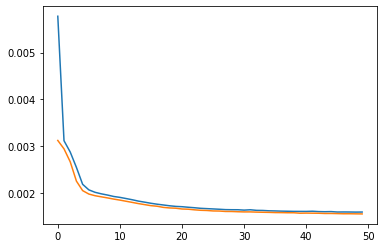

In [ ]:
plt.plot(G_losses_train)
plt.plot(G_losses_valid)

In [ ]:
def test_model():

  Generator.eval()

  for i in range(10):
    image, augmented_image = valid_set[i]
    #image = transforms.ToTensor()(image)
    #image = image.type(torch.FloatTensor)
    #image = image.unsqueeze(0)
    #image = image*2.0-1

    #transforms.ToPILImage()((image[0]+1)/2).save("real"+str(i)+".jpg")
    transforms.ToPILImage()(image).save("original"+str(i)+".jpg")

    #augmented_image = augment_image(image, i, 1)

    #augmented_image = augmented_image.clamp(0.0, 1.0)

    augmented_image = augmented_image.unsqueeze(0)
    print(augmented_image.shape)

    transforms.ToPILImage()(augmented_image[0]).save("input"+str(i)+".jpg")

    output = Generator(augmented_image.cuda())
    output = (output+1)/2
    output = output.clamp(0.0, 1.0)
    transforms.ToPILImage()(output[0].detach().cpu()).save("result" + str(i) + ".jpg")

  Generator.train()

In [ ]:
test_model()

torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
torch.Size([1, 3, 217, 177])
